In [1]:
import gc
import time
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from xgboost import plot_importance

/Users/a407688/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
is_valid = False

In [29]:
path = ''

In [24]:
def timeFeatures(df):
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow'] = df['datetime'].dt.dayofweek
    df['doy'] = df['datetime'].dt.dayofyear
    df['dteom'] = df['datetime'].dt.daysinmonth - df['datetime'].dt.day
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

In [25]:
start_time = time.time()

In [27]:
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [30]:
train = pd.read_csv(path+"train.csv", skiprows=range(1,127903891), nrows=57000000, usecols=train_columns, dtype=dtypes)
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)

print('[{}] Finished to load data'.format(time.time() - start_time))


[194.92202711105347] Finished to load data


In [35]:
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

In [36]:
train.shape

(57000000, 6)

In [39]:
test.shape

(18790469, 7)

In [69]:
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')
test.drop(['click_id'], axis=1, inplace=True)
gc.collect()

NameError: name 'test' is not defined

In [37]:
nrow_train = train.shape[0]
merge = pd.concat([train, test])

In [43]:
ip_count = merge.groupby(['ip'])['channel'].count().reset_index()

In [45]:
ip_count.columns = ['ip', 'clicks_by_ip']

In [47]:
merget = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge['clicks_by_ip'] = merget['clicks_by_ip'].astype('uint16')
merge.drop('ip', axis=1, inplace=True)

In [49]:
train = merge[:nrow_train]
test = merge[nrow_train:]

del test, merge
gc.collect()

710

In [51]:
print('[{}] Start to generate time features'.format(time.time() - start_time))


[2313.136573076248] Start to generate time features


In [52]:
train = timeFeatures(train)
gc.collect()


/Users/a407688/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/a407688/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/a407688/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

7

In [53]:
train

,app,channel,click_id,device,os,clicks_by_ip,dow,doy,dteom
0,2,237,NaN,1,13,2670,2,312,22
1,9,334,NaN,1,19,1362,2,312,22
2,12,219,NaN,1,19,25724,2,312,22
3,12,145,NaN,1,58,41434,2,312,22
4,21,232,NaN,1,8,709,2,312,22
5,3,280,NaN,1,31,6294,2,312,22
6,9,234,NaN,1,30,5244,2,312,22
7,21,128,NaN,1,13,1495,2,312,22
8,2,219,NaN,1,19,14430,2,312,22
9,12,145,NaN,1,8,709,2,312,22


In [54]:
print('[{}] Start XGBoost Training'.format(time.time() - start_time))


[2388.9905200004578] Start XGBoost Training


In [55]:
params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

In [57]:
if(is_valid == True):
    x1,x2,y1,y2 = train_test_split(train, y, test_size=0.1, random_state=99)
    dtrain = xgb.DMatrix(x1,y1)
    dvalid = xgb.DMatrix(x2,y2)
    del x1,x2,y1,y2
    gc.collect()
    watchlist = [(dtrain, 'train'), (dvalid,'valid')]
    model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds= 25, verbose_eval=5)
    del dvalid
else:
    dtrain = xgb.DMatrix(train,y)
    del train, y
    gc.collect()
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, 15, watchlist, maximize=True, verbose_eval=1)

del dtrain
gc.collect()

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

[0]	train-auc:0.959446
[1]	train-auc:0.962162
[2]	train-auc:0.963742
[3]	train-auc:0.965593
[4]	train-auc:0.965869
[5]	train-auc:0.968818
[6]	train-auc:0.970261
[7]	train-auc:0.971101
[8]	train-auc:0.971904
[9]	train-auc:0.973662
[10]	train-auc:0.975225
[11]	train-auc:0.975992
[12]	train-auc:0.976926
[13]	train-auc:0.977056
[14]	train-auc:0.978186
[3025.052006959915] Finish XGBoost Training


In [58]:
plot_importance(model)

In [59]:
plt.gcf().savefig('feature_importance_xgb.png')

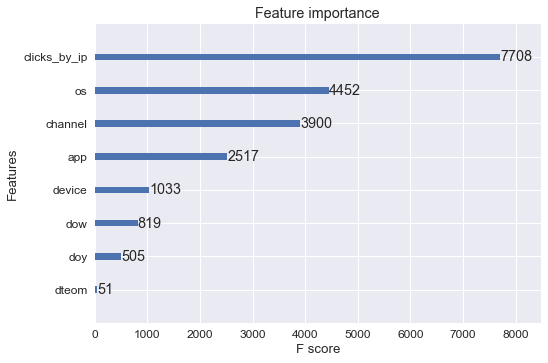

In [60]:
plt.show()

## Prediction for Test

In [61]:
test = pd.read_csv(path+'test.csv', usecols = test_columns, dtype=dtypes)
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)

In [62]:
del ip_count
gc.collect()

400

In [63]:
test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')

In [64]:
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)

In [65]:
dtest = xgb.DMatrix(test)

In [66]:
del test
gc.collect()

70

In [68]:
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub.csv', index=False)

ValueError: feature_names mismatch: ['app', 'channel', 'click_id', 'device', 'os', 'clicks_by_ip', 'dow', 'doy', 'dteom'] ['app', 'device', 'os', 'channel', 'clicks_by_ip', 'dow', 'doy', 'dteom']
expected click_id in input data

In [71]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Change this for validation with 10% from train
is_valid = False

path = ''

def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df["doy"]      = df["datetime"].dt.dayofyear
    df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

start_time = time.time()

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

# Read the last lines because they are more impacting in training than the starting lines
train = pd.read_csv(path+"train.csv", skiprows=range(1,127903891), nrows=57000000, usecols=train_columns, dtype=dtypes)
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)

print('[{}] Finished to load data'.format(time.time() - start_time))

# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

# Drop IP and ID from test rows
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')
test.drop(['click_id'], axis=1, inplace=True)
gc.collect()

nrow_train = train.shape[0]
merge = pd.concat([train, test])

del train, test
gc.collect()

# Count the number of clicks by ip
ip_count = merge.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
merge.drop('ip', axis=1, inplace=True)

train = merge[:nrow_train]
test = merge[nrow_train:]

del test, merge
gc.collect()

print('[{}] Start to generate time features'.format(time.time() - start_time))

train = timeFeatures(train)
gc.collect()

print('[{}] Start XGBoost Training'.format(time.time() - start_time))

# Set the params(this params from Pranav kernel) for xgboost model
params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}
          

if (is_valid == True):
    # Get 10% of train dataset to use as validation
    x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
    dtrain = xgb.DMatrix(x1, y1)
    dvalid = xgb.DMatrix(x2, y2)
    del x1, y1, x2, y2 
    gc.collect()
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
    del dvalid
else:
    dtrain = xgb.DMatrix(train, y)
    del train, y
    gc.collect()
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, 15, watchlist, maximize=True, verbose_eval=1)

del dtrain
gc.collect()

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

# Plot the feature importance from xgboost
plot_importance(model)
plt.gcf().savefig('feature_importance_xgb.png')

# Load the test for predict 
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
del ip_count
gc.collect()

test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)
dtest = xgb.DMatrix(test)
del test
gc.collect()

# Save the predictions
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub.csv',index=False)

[106.69048404693604] Finished to load data
[157.9118206501007] Start to generate time features
[196.03913187980652] Start XGBoost Training
[0]	train-auc:0.958514
[1]	train-auc:0.961067
[2]	train-auc:0.96564
[3]	train-auc:0.963304
[4]	train-auc:0.965242
[5]	train-auc:0.967148
[6]	train-auc:0.96803
[7]	train-auc:0.967361
[8]	train-auc:0.969998
[9]	train-auc:0.969472
[10]	train-auc:0.972521
[11]	train-auc:0.972362
[12]	train-auc:0.973843
[13]	train-auc:0.975896
[14]	train-auc:0.976639
[535.0571348667145] Finish XGBoost Training


In [72]:
chk = pd.read_csv('xgb_sub.csv')

In [73]:
chk.shape

(18790469, 2)